In [1]:

# This program was created to analyze the reliability of using ARIMA to forecast daily stock prices. The program uses stock data as an input, decomposes the trend, and then forecasts
# the trend using the ARIMA. I attempted to transfer this algorithm to Quantopian to backtest and work on it further, but because of the 
# Zipline data types in Quantopian, I was unable to do so as Statsmodels is not compatable with those.



import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import quandl
import numpy as np
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import statsmodels.tsa.stattools as smt
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.seasonal as stats
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

quandl.ApiConfig.api_key = 'T5epsS-txvz9Ce5zz8HC'
df = quandl.get('EOD/HD', start_date='2015-01-01', end_date='2018-01-01')

style.use('ggplot')



df = df['Adj_Close'].ffill()
print(df.tail())
df.index


print(df.head())
print(df.tail())
df = df.resample('D')
df = df.fillna(method='ffill')
log_df = np.log(df)




Date
2017-12-22    182.642265
2017-12-26    184.807216
2017-12-27    184.642175
2017-12-28    184.244134
2017-12-29    184.001427
Name: Adj_Close, dtype: float64
Date
2015-01-02    94.193517
2015-01-05    92.217302
2015-01-06    91.934985
2015-01-07    95.086001
2015-01-08    97.189714
Name: Adj_Close, dtype: float64
Date
2017-12-22    182.642265
2017-12-26    184.807216
2017-12-27    184.642175
2017-12-28    184.244134
2017-12-29    184.001427
Name: Adj_Close, dtype: float64


In [2]:
def test_stationarity(df):
    
    dftest = adfuller(log_df, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        print('critical value:{}'.format(value))
        print(dfoutput[1])
    if dfoutput[1] > value:
        print ('p-value is greater than critical value')
        return 0 #not stationary
test_stationarity(df)

critical value:-3.436369082756128
0.9285914916025356
critical value:-2.8641976875421524
0.9285914916025356
critical value:-2.5681850407995137
0.9285914916025356
p-value is greater than critical value


0

Date
2015-01-07     94.602876
2015-01-08     94.661616
2015-01-09     94.639303
2015-01-10     94.591947
2015-01-11     94.724909
2015-01-12     94.856050
2015-01-13     94.724454
2015-01-14     94.571001
2015-01-15     94.461262
2015-01-16     94.324657
2015-01-17     94.337862
2015-01-18     94.487672
2015-01-19     94.686660
2015-01-20     95.009502
2015-01-21     95.310033
2015-01-22     95.459387
2015-01-23     95.534975
2015-01-24     95.722579
2015-01-25     95.935227
2015-01-26     96.029029
2015-01-27     95.994422
2015-01-28     95.876487
2015-01-29     95.918834
2015-01-30     96.142411
2015-01-31     96.400594
2015-02-01     96.697026
2015-02-02     97.069502
2015-02-03     97.329961
2015-02-04     97.573118
2015-02-05     98.036208
                 ...    
2017-11-25    167.928476
2017-11-26    168.833542
2017-11-27    169.689971
2017-11-28    170.585040
2017-11-29    171.684534
2017-11-30    172.888943
2017-12-01    173.894332
2017-12-02    174.770074
2017-12-03    175.56

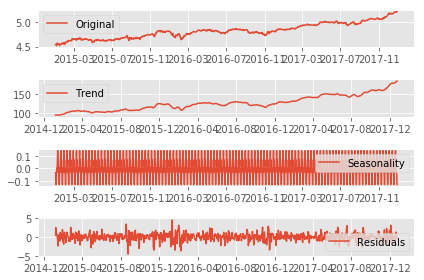

In [3]:
def decompose_data(df):
    decomposition = stats.seasonal_decompose(df,freq=10)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    plt.subplot(411)
    plt.plot(log_df, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    trend.dropna(inplace=True)
    return trend
decompose_data(df)

<class 'pandas.core.series.Series'>


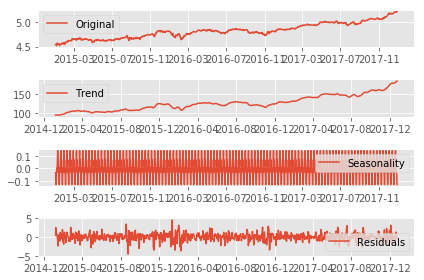

In [4]:
df_log_diff = log_df - log_df.shift()
df_log_diff.dropna(inplace=True)
trend = decompose_data(df)
trend.autocorr(lag=20)
lag_acf = smt.acf(df_log_diff, nlags=20)
lag_pacf = smt.pacf(df_log_diff, nlags=20, method='ols')
lag_acf = acf(df_log_diff, nlags=20)
lag_pacf = pacf(df_log_diff, nlags=20, method='ols')

Text(0.5,1,'Autocorrelation Function')

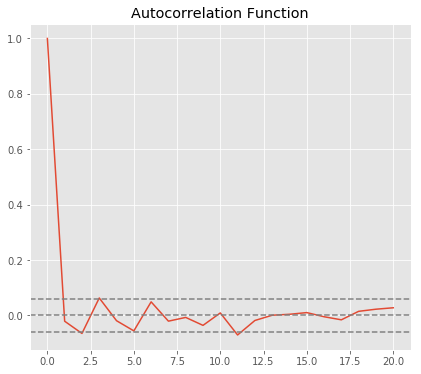

In [113]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

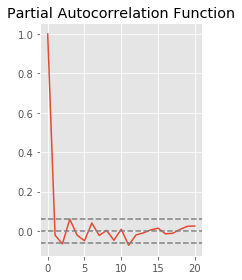

In [5]:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Text(0.5,1,'RSS: nan')

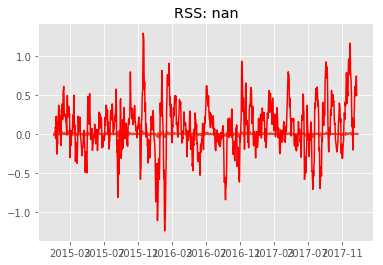

In [6]:
from statsmodels.tsa.arima_model import ARIMA


model = ARIMA(trend, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(df_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-df_log_diff)**2))

Text(0.5,1,'RSS: 0.0924')

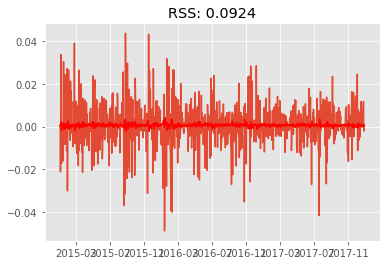

In [7]:
model = ARIMA(log_df, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(df_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-df_log_diff)**2))

Text(0.5,1,'RSS: 0.0928')

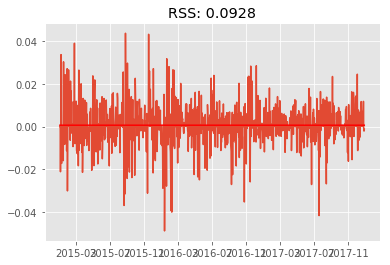

In [8]:
model = ARIMA(log_df, order=(0, 1, 0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(df_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-df_log_diff)**2))

In [9]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Date
2015-01-03    0.000613
2015-01-04    0.000613
2015-01-05    0.000613
2015-01-06    0.000613
2015-01-07    0.000613
Freq: D, dtype: float64


In [10]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print( predictions_ARIMA_diff_cumsum.head())

Date
2015-01-03    0.000613
2015-01-04    0.001226
2015-01-05    0.001840
2015-01-06    0.002453
2015-01-07    0.003066
Freq: D, dtype: float64


In [11]:
predictions_ARIMA_log = pd.Series(log_df.iloc[0], index=log_df.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()


Date
2015-01-02    4.545351
2015-01-03    4.545965
2015-01-04    4.546578
2015-01-05    4.547191
2015-01-06    4.547804
Freq: D, dtype: float64

Date
2015-01-02     95.451631
2015-01-03     95.510178
2015-01-04     95.568761
2015-01-05     95.627379
2015-01-06     95.686034
2015-01-07     95.744725
2015-01-08     95.803452
2015-01-09     95.862214
2015-01-10     95.921013
2015-01-11     95.979848
2015-01-12     96.038719
2015-01-13     96.097626
2015-01-14     96.156569
2015-01-15     96.215548
2015-01-16     96.274564
2015-01-17     96.333615
2015-01-18     96.392703
2015-01-19     96.451828
2015-01-20     96.510988
2015-01-21     96.570185
2015-01-22     96.629418
2015-01-23     96.688687
2015-01-24     96.747993
2015-01-25     96.807335
2015-01-26     96.866713
2015-01-27     96.926128
2015-01-28     96.985579
2015-01-29     97.045067
2015-01-30     97.104592
2015-01-31     97.164152
                 ...    
2017-11-30    183.172698
2017-12-01    183.285050
2017-12-02    183.397471
2017-12-03    183.509962
2017-12-04    183.622521
2017-12-05    183.735149
2017-12-06    183.847846
2017-12-07    183.960612
2017-12-08    184.07

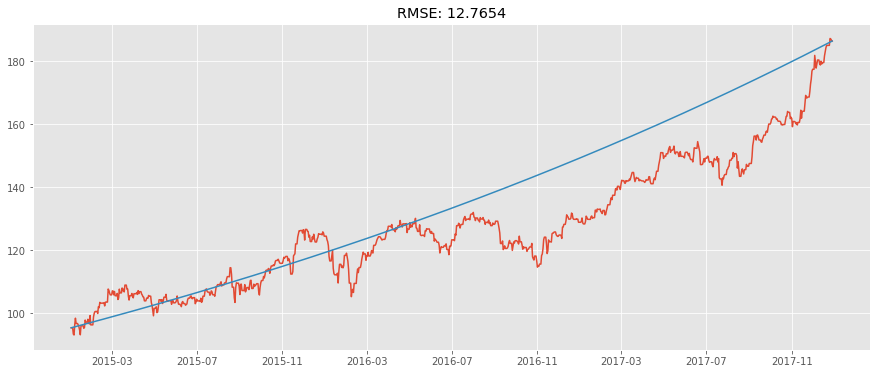

In [130]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df)**2)/len(df)))
print(predictions_ARIMA)

Date
2015-01-02     94.193517
2015-01-03     94.193517
2015-01-04     94.193517
2015-01-05     92.217302
2015-01-06     91.934985
2015-01-07     95.086001
2015-01-08     97.189714
2015-01-09     95.523136
2015-01-10     95.523136
2015-01-11     95.523136
2015-01-12     95.095108
2015-01-13     94.466726
2015-01-14     93.474065
2015-01-15     91.989627
2015-01-16     94.821898
2015-01-17     94.821898
2015-01-18     94.821898
2015-01-19     94.821898
2015-01-20     94.029591
2015-01-21     94.284587
2015-01-22     96.597760
2015-01-23     95.960271
2015-01-24     95.960271
2015-01-25     95.960271
2015-01-26     96.861863
2015-01-27     95.769025
2015-01-28     95.386531
2015-01-29     98.009342
2015-01-30     95.095108
2015-01-31     95.095108
                 ...    
2017-11-30    174.574667
2017-12-01    175.157165
2017-12-02    175.157165
2017-12-03    175.157165
2017-12-04    179.506484
2017-12-05    177.516282
2017-12-06    175.526080
2017-12-07    176.691076
2017-12-08    178.05

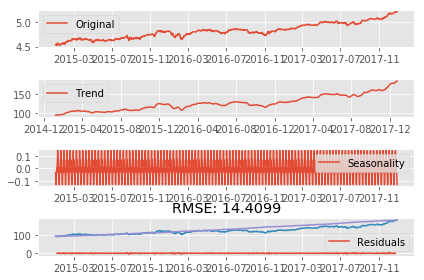

In [12]:

# The analysis shows that using an ARIMA to forecast stock prices could be a profitable trading strategies. 
# Buying securites when the adjusted daily close price is below the forecasted price and shorting the security when
# the current adjusted daily close price is above the forecasted price
















# def tradealgo(df):
#     #try:
#     log_df = np.log(df)
#     df_log_dff = log_df - log_df.shift()
#     df.replace([np.inf, -np.inf], np.nan)
#     df.replace([np.inf, -np.inf], np.nan).dropna(how="all")
#     df.dropna(inplace=True)
#     if test_stationarity(df) == 0: # if not stationary, decompose
#         trend = decompose_data(df)
#         autocorr = trend.autocorr(lag=20)
#         lag_acf = acf(df_log_diff, nlags=20)
#         lag_pacf = pacf(df_log_diff, nlags=20, method='ols')
#         model1 = ARIMA(trend, order=(2, 1, 0))  
#         results_AR = model.fit(disp=-1)  
#         model2 = ARIMA(log_df, order=(0, 1, 2))  
#         results_MA = model.fit(disp=-1) 
#         model3 = ARIMA(log_df, order=(0, 1, 10))  
#         results_ARIMA = model3.fit(disp=-1) 
#         predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
#         predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
#         predictions_ARIMA_log = pd.Series(log_df.iloc[0], index=log_df.index)
#         predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
#         predictions_ARIMA = np.exp(predictions_ARIMA_log)
#         plt.plot(df)
#         plt.plot(predictions_ARIMA)
#         plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df)**2)/len(df)))
#         #if predictions_ARIMA > price:
#             #buy security
#         #    pass
#         #else:
#             #sell security
#          #   pass
    
#     #except:
#       #  print('error')
#     print(predictions_ARIMA)
    
    
# print(df)
        
# tradealgo(df)